# Fruit Classification with Deep Learning

**Author:** Marco Vieto  
**Course:** AIML421 - Victoria University of Wellington  
**Project:** Multi-class fruit classification using PyTorch

## Overview

This notebook implements a comprehensive deep learning pipeline for classifying images of cherries, strawberries, and tomatoes. The project demonstrates:

- **Data preprocessing and augmentation** techniques
- **Multiple model architectures** (MLP, CNN, EfficientNetV2)
- **Hyperparameter optimization** using Optuna
- **Cross-validation** for robust model evaluation
- **Transfer learning** with pre-trained models

## Key Features

1. **Progressive Model Development**: Starting from simple MLP to sophisticated EfficientNetV2
2. **Automated Hyperparameter Tuning**: Using Optuna for optimal performance
3. **Robust Evaluation**: 5-fold cross-validation with comprehensive metrics
4. **Professional Code Quality**: Clean, documented, and reproducible

## Requirements

- PyTorch and torchvision
- Optuna for hyperparameter optimization
- scikit-learn for evaluation metrics
- Standard data science libraries (numpy, pandas, matplotlib, etc.)

## Usage

1. **Update data paths** in the configuration section below
2. **Run all cells sequentially** 
3. **Monitor training progress** through visualizations
4. **Review final evaluation** metrics and confusion matrices

---

### Imports

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.utils.data import Subset, ConcatDataset
from google.colab import drive
import gc
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tqdm import tqdm
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
import optuna
from optuna.trial import Trial
from sklearn.model_selection import KFold
import time
import cv2
import seaborn as sns
import pandas as pd

plt.rcParams.update(
    {
        "font.size": 20,
        "axes.labelpad": 10,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

### Generic Functions

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

### Configuration

Set up random seeds and basic configuration parameters for reproducible results.

In [ ]:
# Mount Google Drive (only for Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except ImportError:
    print("Not running in Google Colab - skipping Drive mount")

Mounted at /content/drive


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device is available. Using GPU.")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.cuda.empty_cache()
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available. Using Apple GPU.")
else:
    device = torch.device("cpu")
    print("Neither CUDA nor MPS is available. Using CPU.")

CUDA device is available. Using GPU.
Using GPU: NVIDIA A100-SXM4-40GB


### Device and Environment Setup

Configure computation device (GPU/MPS/CPU) and data loading parameters.

In [6]:
num_workers = 4 if torch.cuda.is_available() else 0
pin_memory = torch.cuda.is_available()

In [7]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5):

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training')
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            train_bar.set_postfix({
                'loss': f'{running_loss/total:.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc='Validation')
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_bar.set_postfix({
                    'loss': f'{val_loss/val_total:.4f}',
                    'acc': f'{100*val_correct/val_total:.2f}%'
                })

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * val_correct / val_total
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")
        print("-" * 60)


    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = False

    return history

### Training and Evaluation Utilities

Core functions for model training, evaluation, and data handling.

In [9]:
def evaluate_model(model, test_loader, device, classes=None):
    model.eval()
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    if device.type == 'cuda':
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = True

    test_iterator = tqdm(test_loader, desc="Evaluating", leave=False)

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=device.type=='cuda'):
        for inputs, labels in test_iterator:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            current_acc = 100 * correct / total
            test_iterator.set_postfix({'accuracy': f'{current_acc:.2f}%'})

    accuracy = 100 * correct / total

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Print results
    print("\nEvaluation Results:")
    print(f"Test Accuracy: {accuracy:.2f}%")

    if classes is not None:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions, target_names=classes))

        print("\nConfusion Matrix:")
        print("Predicted →")
        print("Actual ↓")
        print(conf_matrix)

    if device.type == 'cuda':
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = False

In [10]:
class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for class_idx, class_name in enumerate(['cherry', 'tomato', 'strawberry']):
            class_path = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_indices(self):
        class_indices = {i: [] for i in range(3)}
        for idx, label in enumerate(self.labels):
            class_indices[label].append(idx)
        return class_indices

In [ ]:
# Data paths - Update these according to your data location
# For Google Colab:
# train_data_path = "/content/drive/My Drive/Colab Notebooks/DATA471/train_data"
# original_train_data_path = "/content/drive/My Drive/Colab Notebooks/DATA471/original_train_data"
# test_data_path = "/content/drive/My Drive/Colab Notebooks/DATA471/test_data"

# For local environment:
train_data_path = "./train_data"
original_train_data_path = "./original_train_data"
test_data_path = "./test_data"

In [12]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(20, 7))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], "b-", label="Training Loss")
    plt.plot(epochs, history["val_loss"], "r-", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], "b-", label="Training Accuracy")
    plt.plot(epochs, history["val_acc"], "r-", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.show()

### EDA & Preprocessing

In [20]:
def get_first_n_per_class(dataset, classes, n=3):
    class_images = {i: [] for i in range(len(classes))}

    for idx in range(len(dataset)):
        _, label = dataset[idx]
        if len(class_images[label]) < n:
            class_images[label].append(idx)

        if all(len(indices) >= n for indices in class_images.values()):
            break

    return class_images

In [21]:
def show_images_comparison(original_dataset, augmented_dataset, classes, num_images=3):
    class_indices = get_first_n_per_class(original_dataset, classes, num_images)

    denorm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    plt.figure(figsize=(15, 5))
    plt.suptitle("Original Images", fontsize=14, y=1.05)

    fig1, axes1 = plt.subplots(len(classes), num_images, figsize=(15, 3 * len(classes)))
    for class_idx, class_name in enumerate(classes):
        for img_idx, idx in enumerate(class_indices[class_idx]):
            img, _ = original_dataset[idx]
            img = denorm(img)
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            axes1[class_idx, img_idx].imshow(img)
            axes1[class_idx, img_idx].axis('off')

            if img_idx == 0:
                axes1[class_idx, img_idx].set_title(f"{class_name}", fontsize=12, pad=10)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.suptitle("Augmented Images", fontsize=14, y=1.05)

    fig2, axes2 = plt.subplots(len(classes), num_images, figsize=(15, 3 * len(classes)))
    for class_idx, class_name in enumerate(classes):
        for img_idx, idx in enumerate(class_indices[class_idx]):
            img, _ = augmented_dataset[idx]
            img = denorm(img)
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)

            axes2[class_idx, img_idx].imshow(img)
            axes2[class_idx, img_idx].axis('off')

            if img_idx == 0:
                axes2[class_idx, img_idx].set_title(f"{class_name}", fontsize=12, pad=10)

    plt.tight_layout()
    plt.show()

In [13]:
def analyze_dataset(dataset):
    class_names = ['cherry', 'tomato', 'strawberry']

    results = {
        'class_stats': [],
        'image_stats': [],
        'color_stats': [],
        'class_distribution': {name: 0 for name in class_names}
    }

    # Get class distribution
    class_indices = dataset.get_class_indices()
    for class_idx, indices in class_indices.items():
        results['class_distribution'][class_names[class_idx]] = len(indices)

    # Analyze each image
    for idx in range(len(dataset)):
        # Get original image path and label
        img_path = dataset.images[idx]
        label = dataset.labels[idx]
        class_name = class_names[label]

        # Load image without transforms for analysis
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        # Basic image statistics
        width, height = img.size
        aspect_ratio = width / height
        file_size = os.path.getsize(img_path) / 1024  # KB

        # Color analysis
        img_hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
        mean_hsv = np.mean(img_hsv, axis=(0,1))
        mean_rgb = np.mean(img_array, axis=(0,1))

        results['image_stats'].append({
            'class': class_name,
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio,
            'file_size_kb': file_size,
            'path': img_path
        })

        results['color_stats'].append({
            'class': class_name,
            'hue_mean': mean_hsv[0],
            'saturation_mean': mean_hsv[1],
            'value_mean': mean_hsv[2],
            'red_mean': mean_rgb[0],
            'green_mean': mean_rgb[1],
            'blue_mean': mean_rgb[2]
        })

    return results

In [14]:
def analyze_concat_dataset(dataset):
    class_names = ['cherry', 'tomato', 'strawberry']

    results = {
        'class_stats': [],
        'image_stats': [],
        'color_stats': [],
        'class_distribution': {name: 0 for name in class_names}
    }

    # Function to get image path and label from any dataset type
    def get_item_info(dataset, idx):
        if isinstance(dataset, ConcatDataset):
            cumulative_sizes = dataset.cumulative_sizes

            # Find which dataset the index belongs to
            dataset_idx = 0
            while dataset_idx < len(cumulative_sizes) and idx >= cumulative_sizes[dataset_idx]:
                dataset_idx += 1

            # Calculate the index within the dataset
            if dataset_idx == 0:
                sample_idx = idx
            else:
                sample_idx = idx - cumulative_sizes[dataset_idx - 1]

            original_dataset = dataset.datasets[dataset_idx]

            # Handle if it's a subset
            if hasattr(original_dataset, 'dataset'):
                original_idx = original_dataset.indices[sample_idx]
                return (original_dataset.dataset.images[original_idx],
                       original_dataset.dataset.labels[original_idx])
            return original_dataset.images[sample_idx], original_dataset.labels[sample_idx]
        else:
            return dataset.images[idx], dataset.labels[idx]

    # Count class distribution using original labels
    for idx in range(len(dataset)):
        _, label = get_item_info(dataset, idx)
        results['class_distribution'][class_names[label]] += 1

    # Analyze each transformed image
    for idx in range(len(dataset)):
        # Get original path and label for reference
        img_path, label = get_item_info(dataset, idx)
        class_name = class_names[label]

        # Get transformed image from dataset
        img_tensor, _ = dataset[idx]

        # Convert tensor to numpy for analysis
        if isinstance(img_tensor, torch.Tensor):
            # Denormalize
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_tensor = img_tensor * std + mean

            img_array = img_tensor.permute(1, 2, 0).numpy()
            img_array = (img_array * 255).astype(np.uint8)

            # Get dimensions from tensor
            _, height, width = img_tensor.shape
        else:
            img_array = np.array(img_tensor)
            height, width = img_array.shape[:2]

        # Basic image statistics
        aspect_ratio = width / height
        file_size = os.path.getsize(img_path) / 1024  # KB

        results['image_stats'].append({
            'class': class_name,
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio,
            'file_size_kb': file_size,
            'path': img_path
        })

        # Color analysis
        img_hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
        mean_hsv = np.mean(img_hsv, axis=(0,1))
        mean_rgb = np.mean(img_array, axis=(0,1))

        results['color_stats'].append({
            'class': class_name,
            'hue_mean': mean_hsv[0],
            'saturation_mean': mean_hsv[1],
            'value_mean': mean_hsv[2],
            'red_mean': mean_rgb[0],
            'green_mean': mean_rgb[1],
            'blue_mean': mean_rgb[2]
        })

    return results

In [15]:
def get_dataset_summary(results):
    df_stats = pd.DataFrame(results['image_stats'])
    df_color = pd.DataFrame(results['color_stats'])

    summary = {
        'class_distribution': results['class_distribution'],
        'image_size_stats': {
            'mean_width': df_stats['width'].mean(),
            'mean_height': df_stats['height'].mean(),
            'width_range': (df_stats['width'].min(), df_stats['width'].max()),
            'height_range': (df_stats['height'].min(), df_stats['height'].max())
        },
        'class_wise_stats': {
            class_name: {
                'count': count,
                'mean_size': df_stats[df_stats['class'] == class_name]['file_size_kb'].mean(),
                'mean_width': df_stats[df_stats['class'] == class_name]['width'].mean(),
                'mean_height': df_stats[df_stats['class'] == class_name]['height'].mean(),
                'mean_aspect_ratio': df_stats[df_stats['class'] == class_name]['aspect_ratio'].mean(),
                'mean_hue': df_color[df_color['class'] == class_name]['hue_mean'].mean(),
                'mean_saturation': df_color[df_color['class'] == class_name]['saturation_mean'].mean()
            }
            for class_name, count in results['class_distribution'].items()
        }
    }

    return summary

In [16]:
dataset = FruitDataset(original_train_data_path)

In [17]:
results = analyze_dataset(dataset)

In [18]:
# Get summary statistics
summary = get_dataset_summary(results)

In [19]:
# Print summary
print("\nDataset Summary:")
print(f"Total images: {sum(results['class_distribution'].values())}")
for class_name, stats in summary['class_wise_stats'].items():
    print(f"\n{class_name.capitalize()} class:")
    print(f"- Count: {stats['count']} images")
    print(f"- Mean file size: {stats['mean_size']:.2f} KB")
    print(f"- Mean width: {stats['mean_width']:.2f} pixels")
    print(f"- Mean height: {stats['mean_height']:.2f} pixels")
    print(f"- Mean aspect ratio: {stats['mean_aspect_ratio']:.2f}")
    print(f"- Mean hue: {stats['mean_hue']:.2f}")
    print(f"- Mean saturation: {stats['mean_saturation']:.2f}")



Dataset Summary:
Total images: 4485

Cherry class:
- Count: 1495 images
- Mean file size: 15.18 KB
- Mean width: 299.18 pixels
- Mean height: 299.15 pixels
- Mean aspect ratio: 1.00
- Mean hue: 64.06
- Mean saturation: 126.52

Tomato class:
- Count: 1495 images
- Mean file size: 15.02 KB
- Mean width: 300.08 pixels
- Mean height: 299.91 pixels
- Mean aspect ratio: 1.00
- Mean hue: 42.07
- Mean saturation: 132.19

Strawberry class:
- Count: 1495 images
- Mean file size: 15.98 KB
- Mean width: 299.35 pixels
- Mean height: 298.95 pixels
- Mean aspect ratio: 1.00
- Mean hue: 54.64
- Mean saturation: 114.62


In [37]:
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [38]:
# Augmented transform
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1,
    ),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [39]:
train_dataset = FruitDataset(data_dir=train_data_path, transform=transform)
augmented_train_dataset = FruitDataset(
    data_dir=train_data_path, transform=augmented_transform
)

In [40]:
class_indices = augmented_train_dataset.get_class_indices()

In [41]:
selected_indices = []
for class_idx in class_indices:
    class_size = len(class_indices[class_idx])
    half_size = class_size // 2
    selected_class_indices = np.random.choice(
        class_indices[class_idx], size=half_size, replace=False
    )
    selected_indices.extend(selected_class_indices)

In [42]:
half_augmented_dataset = Subset(augmented_train_dataset, selected_indices)
full_train_dataset = ConcatDataset([train_dataset, half_augmented_dataset])

In [43]:
results = analyze_concat_dataset(full_train_dataset)

In [44]:
# Get summary statistics
summary = get_dataset_summary(results)

In [45]:
# Print summary
print("\nDataset Summary:")
print(f"Total images: {sum(results['class_distribution'].values())}")
for class_name, stats in summary['class_wise_stats'].items():
    print(f"\n{class_name.capitalize()} class:")
    print(f"- Count: {stats['count']} images")
    print(f"- Mean file size: {stats['mean_size']:.2f} KB")
    print(f"- Mean width: {stats['mean_width']:.2f} pixels")
    print(f"- Mean height: {stats['mean_height']:.2f} pixels")
    print(f"- Mean aspect ratio: {stats['mean_aspect_ratio']:.2f}")
    print(f"- Mean hue: {stats['mean_hue']:.2f}")
    print(f"- Mean saturation: {stats['mean_saturation']:.2f}")


Dataset Summary:
Total images: 8788

Cherry class:
- Count: 2887 images
- Mean file size: 15.19 KB
- Mean width: 384.00 pixels
- Mean height: 384.00 pixels
- Mean aspect ratio: 1.00
- Mean hue: 59.84
- Mean saturation: 117.86

Tomato class:
- Count: 2928 images
- Mean file size: 14.85 KB
- Mean width: 384.00 pixels
- Mean height: 384.00 pixels
- Mean aspect ratio: 1.00
- Mean hue: 41.28
- Mean saturation: 125.68

Strawberry class:
- Count: 2973 images
- Mean file size: 16.79 KB
- Mean width: 384.00 pixels
- Mean height: 384.00 pixels
- Mean aspect ratio: 1.00
- Mean hue: 51.78
- Mean saturation: 110.76


<Figure size 1500x500 with 0 Axes>

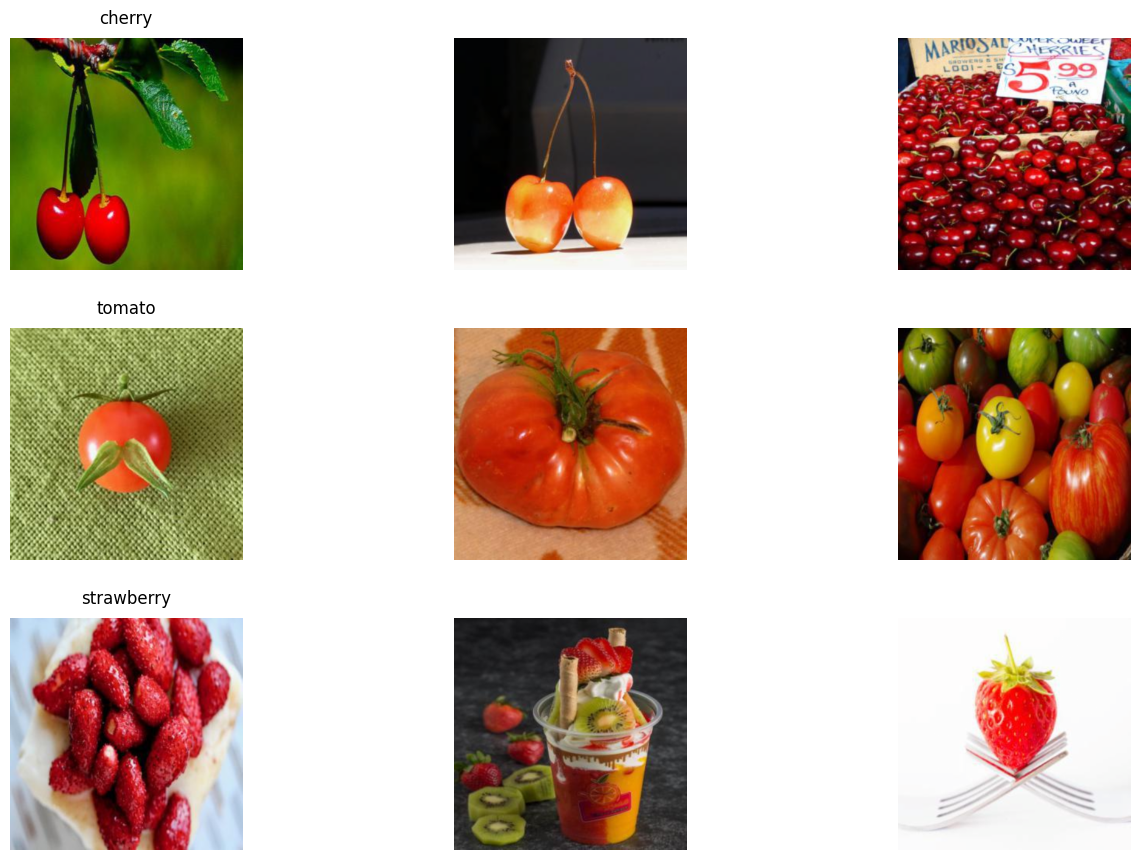

<Figure size 1500x500 with 0 Axes>

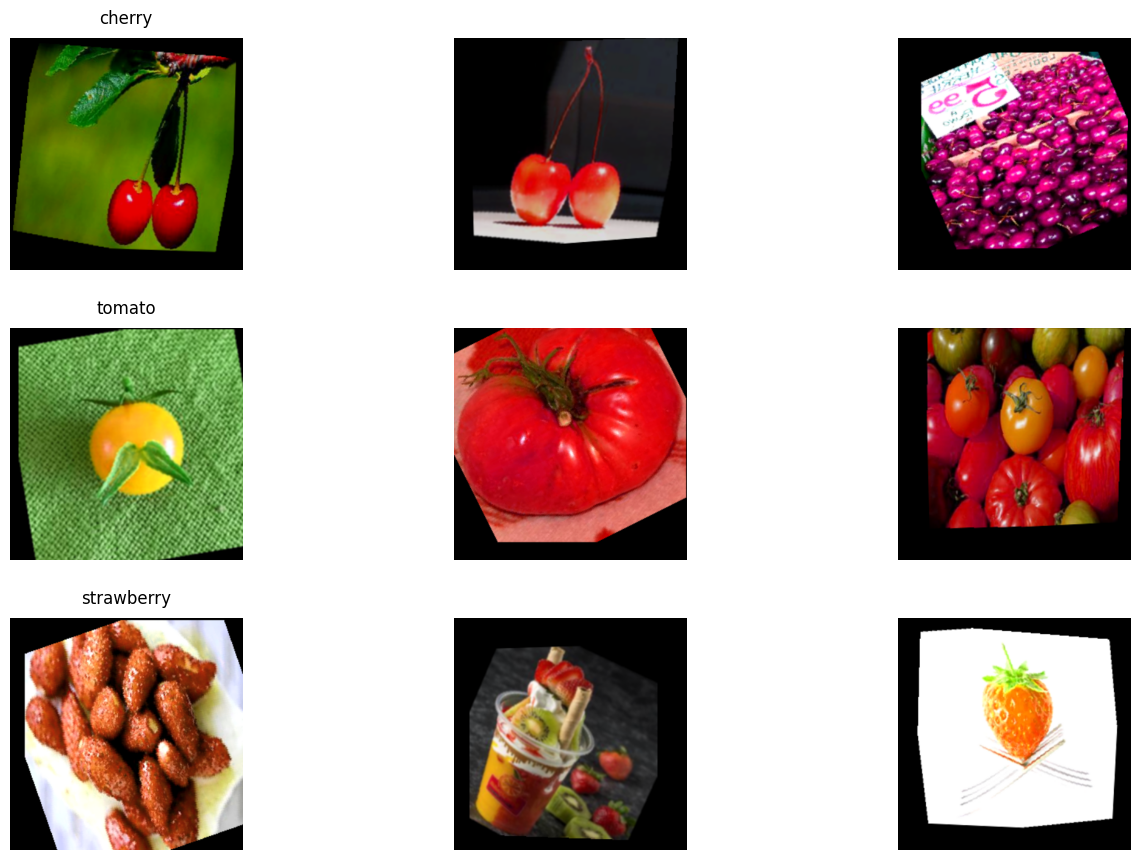

In [46]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

show_images_comparison(
    train_dataset,
    augmented_train_dataset,
    classes=["cherry", "tomato", "strawberry"]
)

In [47]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

In [48]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, worker_init_fn=seed_worker, generator=g)

In [49]:
test_dataset = FruitDataset(data_dir=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, worker_init_fn=seed_worker, generator=g)

### MLP

In [ ]:
class FruitClassifier(nn.Module):
    def __init__(self):
        super(FruitClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(384*384*3, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

In [ ]:
model = FruitClassifier().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
history = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10
)

Validation: 100%|██████████| 55/55 [00:07<00:00,  7.72it/s, loss=0.1954, acc=41.41%]



Epoch 1/10
Train Loss: 37.5884, Train Acc: 41.22%
Val Loss: 6.2461, Val Acc: 41.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.37it/s, loss=0.1521, acc=39.53%]



Epoch 2/10
Train Loss: 5.6174, Train Acc: 44.20%
Val Loss: 4.8617, Val Acc: 39.53%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  7.96it/s, loss=0.2037, acc=42.09%]



Epoch 3/10
Train Loss: 4.2757, Train Acc: 45.72%
Val Loss: 6.5107, Val Acc: 42.09%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.09it/s, loss=0.1636, acc=42.32%]



Epoch 4/10
Train Loss: 5.7696, Train Acc: 44.14%
Val Loss: 5.2284, Val Acc: 42.32%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.08it/s, loss=0.3959, acc=40.78%]



Epoch 5/10
Train Loss: 5.5035, Train Acc: 45.52%
Val Loss: 12.6553, Val Acc: 40.78%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.10it/s, loss=0.2989, acc=40.96%]



Epoch 6/10
Train Loss: 7.4274, Train Acc: 43.74%
Val Loss: 9.5526, Val Acc: 40.96%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.25it/s, loss=0.2262, acc=40.10%]



Epoch 7/10
Train Loss: 8.0438, Train Acc: 43.78%
Val Loss: 7.2298, Val Acc: 40.10%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:07<00:00,  7.73it/s, loss=0.1983, acc=44.43%]



Epoch 8/10
Train Loss: 8.8638, Train Acc: 43.95%
Val Loss: 6.3384, Val Acc: 44.43%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  7.92it/s, loss=0.4413, acc=40.39%]



Epoch 9/10
Train Loss: 9.9138, Train Acc: 44.34%
Val Loss: 14.1048, Val Acc: 40.39%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:07<00:00,  7.69it/s, loss=0.2314, acc=41.75%]


Epoch 10/10
Train Loss: 11.9709, Train Acc: 43.68%
Val Loss: 7.3966, Val Acc: 41.75%
------------------------------------------------------------


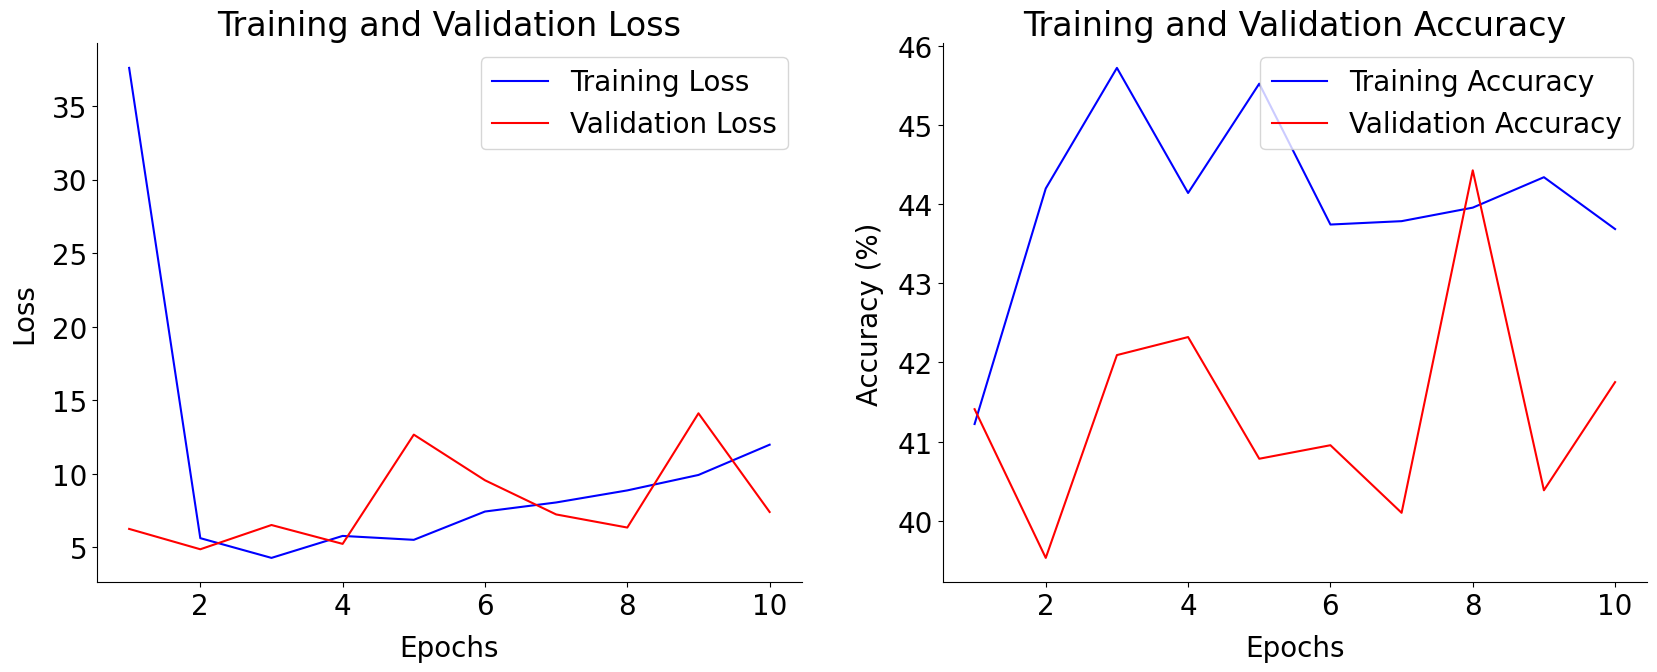

In [ ]:
plot_training_history(history)

In [ ]:
evaluate_model(model, test_loader, device, classes=["cherry", "tomato", "strawberry"])


Evaluation Results:
Test Accuracy: 46.53%

Classification Report:
              precision    recall  f1-score   support

      cherry       0.60      0.41      0.49       500
      tomato       0.43      0.81      0.56       500
  strawberry       0.40      0.18      0.25       500

    accuracy                           0.47      1500
   macro avg       0.48      0.47      0.43      1500
weighted avg       0.48      0.47      0.43      1500


Confusion Matrix:
Predicted →
Actual ↓
[[204 208  88]
 [ 51 403  46]
 [ 85 324  91]]


### CNN

In [ ]:
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1
        )
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten_size = 128 * 37 * 37

        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

Validation: 100%|██████████| 55/55 [00:07<00:00,  7.68it/s, loss=0.0294, acc=58.76%]



Epoch 1/10
Train Loss: 1.4616, Train Acc: 49.87%
Val Loss: 0.9395, Val Acc: 58.76%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.28it/s, loss=0.0260, acc=64.45%]



Epoch 2/10
Train Loss: 0.9118, Train Acc: 57.40%
Val Loss: 0.8324, Val Acc: 64.45%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:07<00:00,  7.80it/s, loss=0.0260, acc=61.72%]



Epoch 3/10
Train Loss: 0.8668, Train Acc: 61.08%
Val Loss: 0.8299, Val Acc: 61.72%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.15it/s, loss=0.0236, acc=68.49%]



Epoch 4/10
Train Loss: 0.8141, Train Acc: 64.57%
Val Loss: 0.7529, Val Acc: 68.49%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  7.93it/s, loss=0.0225, acc=69.80%]



Epoch 5/10
Train Loss: 0.7691, Train Acc: 66.36%
Val Loss: 0.7207, Val Acc: 69.80%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.24it/s, loss=0.0269, acc=62.80%]



Epoch 6/10
Train Loss: 0.7272, Train Acc: 69.02%
Val Loss: 0.8601, Val Acc: 62.80%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.20it/s, loss=0.0212, acc=71.62%]



Epoch 7/10
Train Loss: 0.7071, Train Acc: 70.50%
Val Loss: 0.6781, Val Acc: 71.62%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.09it/s, loss=0.0197, acc=73.55%]



Epoch 8/10
Train Loss: 0.6599, Train Acc: 72.67%
Val Loss: 0.6295, Val Acc: 73.55%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.00it/s, loss=0.0202, acc=73.15%]



Epoch 9/10
Train Loss: 0.6398, Train Acc: 73.23%
Val Loss: 0.6468, Val Acc: 73.15%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:06<00:00,  8.19it/s, loss=0.0207, acc=73.09%]


Epoch 10/10
Train Loss: 0.6200, Train Acc: 74.41%
Val Loss: 0.6631, Val Acc: 73.09%
------------------------------------------------------------


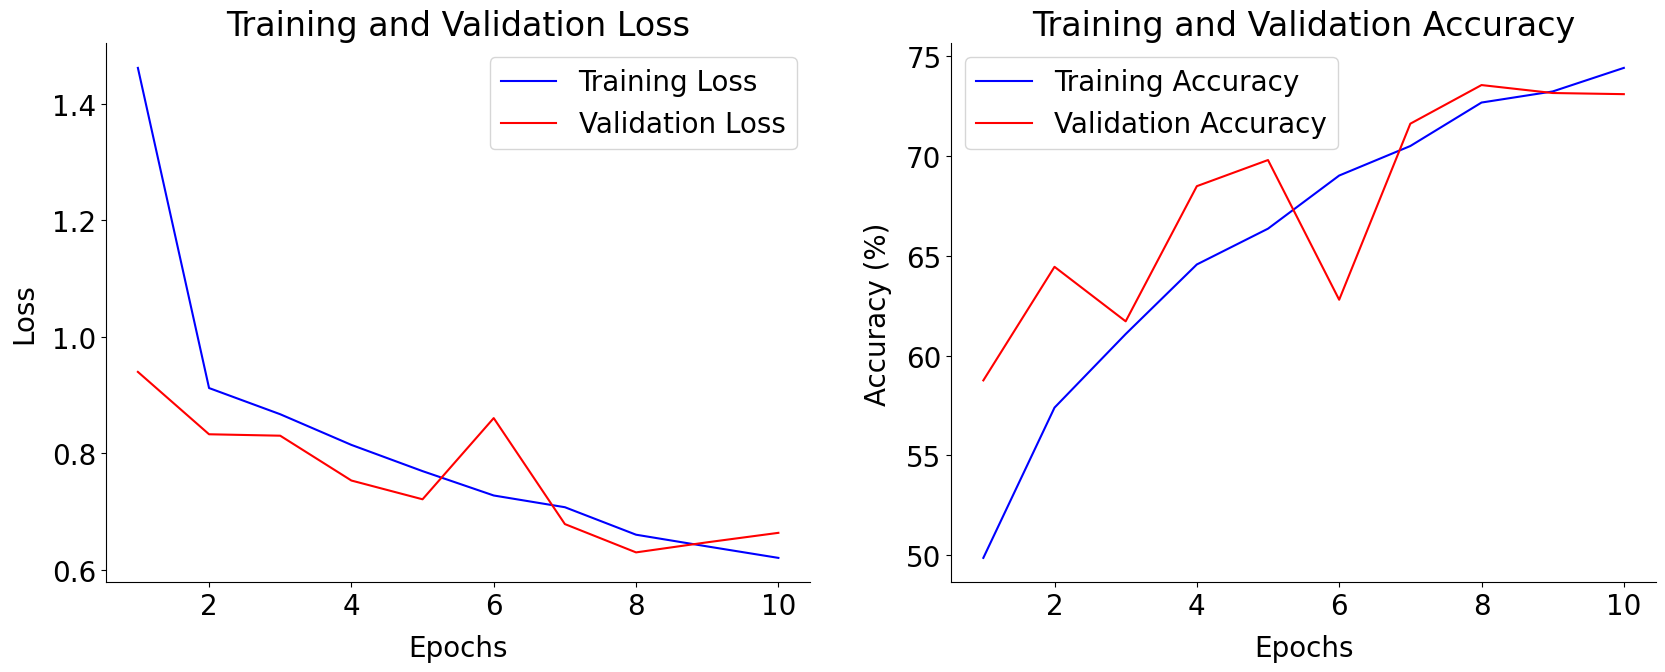

In [ ]:
plot_training_history(history)

In [ ]:
evaluate_model(model, test_loader, device, classes=["cherry", "tomato", "strawberry"])


Evaluation Results:
Test Accuracy: 88.67%

Classification Report:
              precision    recall  f1-score   support

      cherry       0.92      0.82      0.86       500
      tomato       0.86      0.95      0.90       500
  strawberry       0.89      0.89      0.89       500

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500


Confusion Matrix:
Predicted →
Actual ↓
[[409  44  47]
 [ 15 474  11]
 [ 22  31 447]]


### EfficientNetV2

In [ ]:
class FruitClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(FruitClassifier, self).__init__()

        # Load pretrained EfficientNetV2
        weights = EfficientNet_V2_S_Weights.DEFAULT
        self.efficient_net = efficientnet_v2_s(weights=weights)

        # Get the number of features in the last layer
        num_features = self.efficient_net.classifier[1].in_features

        # Replace the classifier
        self.efficient_net.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.efficient_net(x)

In [ ]:
def objective(trial: Trial):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.0001])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD'])

    # Create model
    model = FruitClassifier().to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    # Select optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:  # SGD
        momentum = trial.suggest_float('momentum', 0.8, 0.99)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        worker_init_fn=seed_worker,
        generator=g)

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        worker_init_fn=seed_worker,
        generator=g)

    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=10
    )

    # Get the best validation accuracy
    best_val_acc = max(history['val_acc'])

    return best_val_acc

### Hyperparameter Optimization

Automated hyperparameter tuning using Optuna to find optimal model configurations.

In [ ]:
def run_optuna_study(n_trials=30):
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    print("\nBest trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study

In [ ]:
study = run_optuna_study(n_trials=30)

[I 2024-10-27 04:17:28,795] A new study created in memory with name: no-name-8fb0eaef-3519-46d8-9da9-fadf6c0352e8
Validation: 100%|██████████| 110/110 [00:10<00:00, 10.56it/s, loss=0.0639, acc=74.57%]



Epoch 1/10
Train Loss: 1.0665, Train Acc: 50.37%
Val Loss: 1.0215, Val Acc: 74.57%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:10<00:00, 10.88it/s, loss=0.0548, acc=86.86%]



Epoch 2/10
Train Loss: 0.9581, Train Acc: 74.77%
Val Loss: 0.8752, Val Acc: 86.86%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:10<00:00, 10.95it/s, loss=0.0358, acc=90.16%]



Epoch 3/10
Train Loss: 0.7344, Train Acc: 83.76%
Val Loss: 0.5718, Val Acc: 90.16%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:10<00:00, 10.83it/s, loss=0.0229, acc=91.41%]



Epoch 4/10
Train Loss: 0.4837, Train Acc: 87.43%
Val Loss: 0.3667, Val Acc: 91.41%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:10<00:00, 10.85it/s, loss=0.0155, acc=93.57%]



Epoch 5/10
Train Loss: 0.3321, Train Acc: 90.03%
Val Loss: 0.2481, Val Acc: 93.57%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.06it/s, loss=0.0112, acc=95.11%]



Epoch 6/10
Train Loss: 0.2675, Train Acc: 90.77%
Val Loss: 0.1794, Val Acc: 95.11%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:10<00:00, 10.86it/s, loss=0.0092, acc=96.13%]



Epoch 7/10
Train Loss: 0.2207, Train Acc: 92.32%
Val Loss: 0.1464, Val Acc: 96.13%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.06it/s, loss=0.0083, acc=95.68%]



Epoch 8/10
Train Loss: 0.2002, Train Acc: 93.20%
Val Loss: 0.1319, Val Acc: 95.68%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:10<00:00, 10.93it/s, loss=0.0063, acc=96.59%]



Epoch 9/10
Train Loss: 0.1825, Train Acc: 93.67%
Val Loss: 0.1015, Val Acc: 96.59%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:10<00:00, 10.95it/s, loss=0.0058, acc=97.21%]
[I 2024-10-27 04:27:14,043] Trial 0 finished with value: 97.2127417519909 and parameters: {'learning_rate': 0.0001, 'batch_size': 16, 'optimizer': 'SGD', 'momentum': 0.9142118522312097}. Best is trial 0 with value: 97.2127417519909.



Epoch 10/10
Train Loss: 0.1579, Train Acc: 94.62%
Val Loss: 0.0930, Val Acc: 97.21%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.47it/s, loss=0.0073, acc=96.42%]



Epoch 1/10
Train Loss: 0.5618, Train Acc: 79.56%
Val Loss: 0.1172, Val Acc: 96.42%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.98it/s, loss=0.0043, acc=97.84%]



Epoch 2/10
Train Loss: 0.1471, Train Acc: 94.99%
Val Loss: 0.0681, Val Acc: 97.84%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.55it/s, loss=0.0033, acc=98.12%]



Epoch 3/10
Train Loss: 0.1101, Train Acc: 96.12%
Val Loss: 0.0533, Val Acc: 98.12%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.57it/s, loss=0.0033, acc=98.29%]



Epoch 4/10
Train Loss: 0.0701, Train Acc: 97.54%
Val Loss: 0.0524, Val Acc: 98.29%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.73it/s, loss=0.0025, acc=98.69%]



Epoch 5/10
Train Loss: 0.0571, Train Acc: 98.05%
Val Loss: 0.0400, Val Acc: 98.69%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.93it/s, loss=0.0027, acc=98.75%]



Epoch 6/10
Train Loss: 0.0462, Train Acc: 98.55%
Val Loss: 0.0425, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.82it/s, loss=0.0021, acc=98.92%]



Epoch 7/10
Train Loss: 0.0370, Train Acc: 98.79%
Val Loss: 0.0341, Val Acc: 98.92%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.44it/s, loss=0.0021, acc=98.75%]



Epoch 8/10
Train Loss: 0.0337, Train Acc: 98.86%
Val Loss: 0.0338, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.69it/s, loss=0.0019, acc=99.03%]



Epoch 9/10
Train Loss: 0.0275, Train Acc: 99.12%
Val Loss: 0.0305, Val Acc: 99.03%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.74it/s, loss=0.0021, acc=98.98%]
[I 2024-10-27 04:36:37,695] Trial 1 finished with value: 99.032992036405 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'SGD', 'momentum': 0.8997037220101252}. Best is trial 1 with value: 99.032992036405.



Epoch 10/10
Train Loss: 0.0213, Train Acc: 99.25%
Val Loss: 0.0335, Val Acc: 98.98%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.68it/s, loss=0.0142, acc=93.12%]



Epoch 1/10
Train Loss: 0.7006, Train Acc: 77.58%
Val Loss: 0.2261, Val Acc: 93.12%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.67it/s, loss=0.0056, acc=97.21%]



Epoch 2/10
Train Loss: 0.2101, Train Acc: 92.82%
Val Loss: 0.0894, Val Acc: 97.21%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.80it/s, loss=0.0043, acc=97.95%]



Epoch 3/10
Train Loss: 0.1429, Train Acc: 94.74%
Val Loss: 0.0685, Val Acc: 97.95%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.58it/s, loss=0.0035, acc=98.18%]



Epoch 4/10
Train Loss: 0.1022, Train Acc: 96.30%
Val Loss: 0.0556, Val Acc: 98.18%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.38it/s, loss=0.0033, acc=98.18%]



Epoch 5/10
Train Loss: 0.0882, Train Acc: 97.03%
Val Loss: 0.0522, Val Acc: 98.18%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.49it/s, loss=0.0030, acc=98.24%]



Epoch 6/10
Train Loss: 0.0754, Train Acc: 97.41%
Val Loss: 0.0484, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.72it/s, loss=0.0023, acc=98.69%]



Epoch 7/10
Train Loss: 0.0667, Train Acc: 97.99%
Val Loss: 0.0373, Val Acc: 98.69%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.65it/s, loss=0.0024, acc=98.86%]



Epoch 8/10
Train Loss: 0.0485, Train Acc: 98.38%
Val Loss: 0.0378, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.64it/s, loss=0.0030, acc=98.46%]



Epoch 9/10
Train Loss: 0.0467, Train Acc: 98.58%
Val Loss: 0.0474, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.74it/s, loss=0.0023, acc=98.35%]
[I 2024-10-27 04:46:02,290] Trial 2 finished with value: 98.86234357224119 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'SGD', 'momentum': 0.8379380186100884}. Best is trial 1 with value: 99.032992036405.



Epoch 10/10
Train Loss: 0.0384, Train Acc: 98.69%
Val Loss: 0.0367, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.60it/s, loss=0.0319, acc=78.67%]



Epoch 1/10
Train Loss: 1.0660, Train Acc: 51.01%
Val Loss: 1.0197, Val Acc: 78.67%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.72it/s, loss=0.0279, acc=86.18%]



Epoch 2/10
Train Loss: 0.9682, Train Acc: 75.09%
Val Loss: 0.8919, Val Acc: 86.18%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.66it/s, loss=0.0200, acc=88.74%]



Epoch 3/10
Train Loss: 0.7770, Train Acc: 84.84%
Val Loss: 0.6382, Val Acc: 88.74%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.92it/s, loss=0.0122, acc=91.52%]



Epoch 4/10
Train Loss: 0.5198, Train Acc: 88.71%
Val Loss: 0.3888, Val Acc: 91.52%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.78it/s, loss=0.0079, acc=93.52%]



Epoch 5/10
Train Loss: 0.3506, Train Acc: 90.18%
Val Loss: 0.2516, Val Acc: 93.52%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.80it/s, loss=0.0061, acc=94.94%]



Epoch 6/10
Train Loss: 0.2578, Train Acc: 92.11%
Val Loss: 0.1936, Val Acc: 94.94%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.69it/s, loss=0.0045, acc=96.30%]



Epoch 7/10
Train Loss: 0.2106, Train Acc: 93.03%
Val Loss: 0.1428, Val Acc: 96.30%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.71it/s, loss=0.0039, acc=96.30%]



Epoch 8/10
Train Loss: 0.1770, Train Acc: 94.13%
Val Loss: 0.1253, Val Acc: 96.30%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.69it/s, loss=0.0033, acc=96.87%]



Epoch 9/10
Train Loss: 0.1500, Train Acc: 94.91%
Val Loss: 0.1043, Val Acc: 96.87%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.72it/s, loss=0.0029, acc=96.99%]
[I 2024-10-27 04:53:51,698] Trial 3 finished with value: 96.98521046643914 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9535954961421276}. Best is trial 1 with value: 99.032992036405.



Epoch 10/10
Train Loss: 0.1384, Train Acc: 95.26%
Val Loss: 0.0916, Val Acc: 96.99%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.57it/s, loss=0.0136, acc=94.88%]



Epoch 1/10
Train Loss: 0.7087, Train Acc: 76.22%
Val Loss: 0.2167, Val Acc: 94.88%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.52it/s, loss=0.0053, acc=97.44%]



Epoch 2/10
Train Loss: 0.2018, Train Acc: 93.27%
Val Loss: 0.0846, Val Acc: 97.44%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.78it/s, loss=0.0050, acc=96.76%]



Epoch 3/10
Train Loss: 0.1295, Train Acc: 95.38%
Val Loss: 0.0805, Val Acc: 96.76%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.43it/s, loss=0.0030, acc=98.46%]



Epoch 4/10
Train Loss: 0.0979, Train Acc: 96.36%
Val Loss: 0.0486, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.64it/s, loss=0.0026, acc=98.69%]



Epoch 5/10
Train Loss: 0.0808, Train Acc: 97.24%
Val Loss: 0.0419, Val Acc: 98.69%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.67it/s, loss=0.0030, acc=98.35%]



Epoch 6/10
Train Loss: 0.0679, Train Acc: 97.58%
Val Loss: 0.0486, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.67it/s, loss=0.0027, acc=98.52%]



Epoch 7/10
Train Loss: 0.0504, Train Acc: 98.32%
Val Loss: 0.0426, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.56it/s, loss=0.0023, acc=98.75%]



Epoch 8/10
Train Loss: 0.0383, Train Acc: 98.61%
Val Loss: 0.0372, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.71it/s, loss=0.0022, acc=98.69%]



Epoch 9/10
Train Loss: 0.0325, Train Acc: 98.95%
Val Loss: 0.0348, Val Acc: 98.69%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.70it/s, loss=0.0024, acc=98.75%]
[I 2024-10-27 05:03:18,209] Trial 4 finished with value: 98.7485779294653 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'SGD', 'momentum': 0.8491681965040032}. Best is trial 1 with value: 99.032992036405.



Epoch 10/10
Train Loss: 0.0293, Train Acc: 99.02%
Val Loss: 0.0391, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.59it/s, loss=0.0074, acc=91.87%]



Epoch 1/10
Train Loss: 0.3363, Train Acc: 88.36%
Val Loss: 0.2366, Val Acc: 91.87%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s, loss=0.0061, acc=94.03%]



Epoch 2/10
Train Loss: 0.2174, Train Acc: 92.40%
Val Loss: 0.1943, Val Acc: 94.03%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s, loss=0.0069, acc=92.83%]



Epoch 3/10
Train Loss: 0.1728, Train Acc: 93.95%
Val Loss: 0.2203, Val Acc: 92.83%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.62it/s, loss=0.0066, acc=92.78%]



Epoch 4/10
Train Loss: 0.1584, Train Acc: 94.61%
Val Loss: 0.2121, Val Acc: 92.78%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.72it/s, loss=0.0038, acc=95.96%]



Epoch 5/10
Train Loss: 0.1402, Train Acc: 95.02%
Val Loss: 0.1230, Val Acc: 95.96%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.72it/s, loss=0.0037, acc=96.13%]



Epoch 6/10
Train Loss: 0.1196, Train Acc: 96.16%
Val Loss: 0.1188, Val Acc: 96.13%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.68it/s, loss=0.0045, acc=95.62%]



Epoch 7/10
Train Loss: 0.1067, Train Acc: 96.39%
Val Loss: 0.1426, Val Acc: 95.62%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.65it/s, loss=0.0044, acc=94.94%]



Epoch 8/10
Train Loss: 0.0985, Train Acc: 96.77%
Val Loss: 0.1412, Val Acc: 94.94%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.90it/s, loss=0.0050, acc=94.60%]



Epoch 9/10
Train Loss: 0.1064, Train Acc: 96.54%
Val Loss: 0.1589, Val Acc: 94.60%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s, loss=0.0047, acc=94.65%]
[I 2024-10-27 05:11:06,943] Trial 5 finished with value: 96.13196814562002 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 99.032992036405.



Epoch 10/10
Train Loss: 0.0862, Train Acc: 97.04%
Val Loss: 0.1508, Val Acc: 94.65%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.70it/s, loss=0.0121, acc=95.51%]



Epoch 1/10
Train Loss: 0.7051, Train Acc: 76.80%
Val Loss: 0.1942, Val Acc: 95.51%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.70it/s, loss=0.0054, acc=97.38%]



Epoch 2/10
Train Loss: 0.1981, Train Acc: 92.99%
Val Loss: 0.0863, Val Acc: 97.38%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.43it/s, loss=0.0040, acc=97.90%]



Epoch 3/10
Train Loss: 0.1358, Train Acc: 95.22%
Val Loss: 0.0635, Val Acc: 97.90%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.70it/s, loss=0.0033, acc=98.46%]



Epoch 4/10
Train Loss: 0.1042, Train Acc: 96.37%
Val Loss: 0.0529, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.74it/s, loss=0.0028, acc=98.52%]



Epoch 5/10
Train Loss: 0.0774, Train Acc: 97.38%
Val Loss: 0.0443, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.49it/s, loss=0.0027, acc=98.69%]



Epoch 6/10
Train Loss: 0.0635, Train Acc: 97.84%
Val Loss: 0.0427, Val Acc: 98.69%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.55it/s, loss=0.0027, acc=98.63%]



Epoch 7/10
Train Loss: 0.0504, Train Acc: 98.17%
Val Loss: 0.0429, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.62it/s, loss=0.0026, acc=98.81%]



Epoch 8/10
Train Loss: 0.0440, Train Acc: 98.69%
Val Loss: 0.0420, Val Acc: 98.81%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.91it/s, loss=0.0025, acc=98.52%]



Epoch 9/10
Train Loss: 0.0386, Train Acc: 98.76%
Val Loss: 0.0399, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.64it/s, loss=0.0023, acc=98.92%]
[I 2024-10-27 05:20:34,262] Trial 6 finished with value: 98.91922639362912 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'SGD', 'momentum': 0.8515563160370403}. Best is trial 1 with value: 99.032992036405.



Epoch 10/10
Train Loss: 0.0295, Train Acc: 99.06%
Val Loss: 0.0375, Val Acc: 98.92%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.75it/s, loss=0.0040, acc=96.19%]



Epoch 1/10
Train Loss: 0.6209, Train Acc: 78.72%
Val Loss: 0.1284, Val Acc: 96.19%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0021, acc=97.78%]



Epoch 2/10
Train Loss: 0.1357, Train Acc: 95.15%
Val Loss: 0.0683, Val Acc: 97.78%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.77it/s, loss=0.0015, acc=98.41%]



Epoch 3/10
Train Loss: 0.0729, Train Acc: 97.54%
Val Loss: 0.0472, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.62it/s, loss=0.0012, acc=98.41%]



Epoch 4/10
Train Loss: 0.0554, Train Acc: 98.17%
Val Loss: 0.0378, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.79it/s, loss=0.0013, acc=98.41%]



Epoch 5/10
Train Loss: 0.0387, Train Acc: 98.63%
Val Loss: 0.0402, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0012, acc=98.69%]



Epoch 6/10
Train Loss: 0.0393, Train Acc: 98.78%
Val Loss: 0.0394, Val Acc: 98.69%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.85it/s, loss=0.0011, acc=98.63%]



Epoch 7/10
Train Loss: 0.0226, Train Acc: 99.20%
Val Loss: 0.0356, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.70it/s, loss=0.0009, acc=99.20%]



Epoch 8/10
Train Loss: 0.0199, Train Acc: 99.39%
Val Loss: 0.0294, Val Acc: 99.20%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.78it/s, loss=0.0010, acc=99.09%]



Epoch 9/10
Train Loss: 0.0216, Train Acc: 99.29%
Val Loss: 0.0308, Val Acc: 99.09%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.71it/s, loss=0.0008, acc=99.03%]
[I 2024-10-27 05:28:21,533] Trial 7 finished with value: 99.20364050056882 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9467265061663649}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0198, Train Acc: 99.37%
Val Loss: 0.0255, Val Acc: 99.03%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.72it/s, loss=0.0227, acc=87.54%]



Epoch 1/10
Train Loss: 0.4626, Train Acc: 83.07%
Val Loss: 0.3630, Val Acc: 87.54%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.70it/s, loss=0.0234, acc=86.18%]



Epoch 2/10
Train Loss: 0.3232, Train Acc: 88.39%
Val Loss: 0.3742, Val Acc: 86.18%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.58it/s, loss=0.0135, acc=91.87%]



Epoch 3/10
Train Loss: 0.2520, Train Acc: 90.83%
Val Loss: 0.2150, Val Acc: 91.87%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.91it/s, loss=0.0105, acc=94.14%]



Epoch 4/10
Train Loss: 0.2043, Train Acc: 92.75%
Val Loss: 0.1686, Val Acc: 94.14%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.58it/s, loss=0.0172, acc=90.33%]



Epoch 5/10
Train Loss: 0.2236, Train Acc: 92.02%
Val Loss: 0.2754, Val Acc: 90.33%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.63it/s, loss=0.0098, acc=94.60%]



Epoch 6/10
Train Loss: 0.1804, Train Acc: 93.51%
Val Loss: 0.1571, Val Acc: 94.60%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.54it/s, loss=0.0087, acc=94.60%]



Epoch 7/10
Train Loss: 0.1694, Train Acc: 94.03%
Val Loss: 0.1389, Val Acc: 94.60%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.52it/s, loss=0.0136, acc=91.30%]



Epoch 8/10
Train Loss: 0.1675, Train Acc: 94.25%
Val Loss: 0.2180, Val Acc: 91.30%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.77it/s, loss=0.0107, acc=93.52%]



Epoch 9/10
Train Loss: 0.1492, Train Acc: 94.91%
Val Loss: 0.1705, Val Acc: 93.52%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.44it/s, loss=0.0119, acc=93.69%]
[I 2024-10-27 05:37:55,712] Trial 8 finished with value: 94.59613196814561 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.1253, Train Acc: 95.33%
Val Loss: 0.1896, Val Acc: 93.69%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.36it/s, loss=0.0640, acc=76.79%]



Epoch 1/10
Train Loss: 1.0671, Train Acc: 48.34%
Val Loss: 1.0231, Val Acc: 76.79%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.68it/s, loss=0.0514, acc=87.71%]



Epoch 2/10
Train Loss: 0.9358, Train Acc: 75.21%
Val Loss: 0.8222, Val Acc: 87.71%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.80it/s, loss=0.0328, acc=90.73%]



Epoch 3/10
Train Loss: 0.6848, Train Acc: 84.35%
Val Loss: 0.5242, Val Acc: 90.73%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.52it/s, loss=0.0190, acc=92.78%]



Epoch 4/10
Train Loss: 0.4369, Train Acc: 88.15%
Val Loss: 0.3039, Val Acc: 92.78%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.46it/s, loss=0.0136, acc=94.60%]



Epoch 5/10
Train Loss: 0.3034, Train Acc: 90.20%
Val Loss: 0.2171, Val Acc: 94.60%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.26it/s, loss=0.0102, acc=95.39%]



Epoch 6/10
Train Loss: 0.2432, Train Acc: 91.65%
Val Loss: 0.1625, Val Acc: 95.39%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.49it/s, loss=0.0080, acc=96.13%]



Epoch 7/10
Train Loss: 0.2109, Train Acc: 92.72%
Val Loss: 0.1283, Val Acc: 96.13%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.48it/s, loss=0.0073, acc=96.36%]



Epoch 8/10
Train Loss: 0.1902, Train Acc: 92.99%
Val Loss: 0.1160, Val Acc: 96.36%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.97it/s, loss=0.0063, acc=96.70%]



Epoch 9/10
Train Loss: 0.1570, Train Acc: 94.45%
Val Loss: 0.1012, Val Acc: 96.70%
------------------------------------------------------------


Validation: 100%|██████████| 110/110 [00:09<00:00, 11.43it/s, loss=0.0052, acc=97.55%]
[I 2024-10-27 05:47:24,380] Trial 9 finished with value: 97.55403868031854 and parameters: {'learning_rate': 0.0001, 'batch_size': 16, 'optimizer': 'SGD', 'momentum': 0.9211359195574905}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.1462, Train Acc: 94.89%
Val Loss: 0.0825, Val Acc: 97.55%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0009, acc=97.95%]



Epoch 1/10
Train Loss: 0.2717, Train Acc: 91.74%
Val Loss: 0.0581, Val Acc: 97.95%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0006, acc=98.29%]



Epoch 2/10
Train Loss: 0.0506, Train Acc: 98.32%
Val Loss: 0.0402, Val Acc: 98.29%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.80it/s, loss=0.0007, acc=98.46%]



Epoch 3/10
Train Loss: 0.0356, Train Acc: 98.78%
Val Loss: 0.0432, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s, loss=0.0007, acc=98.35%]



Epoch 4/10
Train Loss: 0.0208, Train Acc: 99.42%
Val Loss: 0.0444, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.73it/s, loss=0.0009, acc=98.18%]



Epoch 5/10
Train Loss: 0.0120, Train Acc: 99.73%
Val Loss: 0.0565, Val Acc: 98.18%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0006, acc=98.98%]



Epoch 6/10
Train Loss: 0.0116, Train Acc: 99.59%
Val Loss: 0.0367, Val Acc: 98.98%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0008, acc=98.58%]



Epoch 7/10
Train Loss: 0.0188, Train Acc: 99.36%
Val Loss: 0.0522, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0009, acc=98.35%]



Epoch 8/10
Train Loss: 0.0105, Train Acc: 99.59%
Val Loss: 0.0565, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.89it/s, loss=0.0008, acc=98.58%]



Epoch 9/10
Train Loss: 0.0143, Train Acc: 99.45%
Val Loss: 0.0502, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0010, acc=98.18%]
[I 2024-10-27 05:55:24,570] Trial 10 finished with value: 98.97610921501706 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'AdamW'}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0103, Train Acc: 99.66%
Val Loss: 0.0627, Val Acc: 98.18%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0083, acc=89.08%]



Epoch 1/10
Train Loss: 0.3464, Train Acc: 87.58%
Val Loss: 0.2641, Val Acc: 89.08%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.50it/s, loss=0.0084, acc=91.35%]



Epoch 2/10
Train Loss: 0.2208, Train Acc: 91.93%
Val Loss: 0.2695, Val Acc: 91.35%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.61it/s, loss=0.0067, acc=92.49%]



Epoch 3/10
Train Loss: 0.1604, Train Acc: 94.38%
Val Loss: 0.2140, Val Acc: 92.49%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.68it/s, loss=0.0037, acc=95.45%]



Epoch 4/10
Train Loss: 0.1573, Train Acc: 94.35%
Val Loss: 0.1190, Val Acc: 95.45%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.78it/s, loss=0.0126, acc=88.57%]



Epoch 5/10
Train Loss: 0.1263, Train Acc: 95.78%
Val Loss: 0.4013, Val Acc: 88.57%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.74it/s, loss=0.0037, acc=95.62%]



Epoch 6/10
Train Loss: 0.1220, Train Acc: 95.86%
Val Loss: 0.1191, Val Acc: 95.62%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.58it/s, loss=0.0051, acc=94.82%]



Epoch 7/10
Train Loss: 0.1188, Train Acc: 95.82%
Val Loss: 0.1625, Val Acc: 94.82%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.81it/s, loss=0.0057, acc=93.23%]



Epoch 8/10
Train Loss: 0.1068, Train Acc: 96.10%
Val Loss: 0.1807, Val Acc: 93.23%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s, loss=0.0025, acc=97.21%]



Epoch 9/10
Train Loss: 0.1025, Train Acc: 96.32%
Val Loss: 0.0786, Val Acc: 97.21%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s, loss=0.0032, acc=96.53%]
[I 2024-10-27 06:03:16,185] Trial 11 finished with value: 97.2127417519909 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'AdamW'}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0903, Train Acc: 96.91%
Val Loss: 0.1037, Val Acc: 96.53%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.91it/s, loss=0.0026, acc=94.14%]



Epoch 1/10
Train Loss: 0.7627, Train Acc: 73.49%
Val Loss: 0.1604, Val Acc: 94.14%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0013, acc=97.50%]



Epoch 2/10
Train Loss: 0.1333, Train Acc: 95.43%
Val Loss: 0.0834, Val Acc: 97.50%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0011, acc=97.55%]



Epoch 3/10
Train Loss: 0.0666, Train Acc: 97.84%
Val Loss: 0.0678, Val Acc: 97.55%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0008, acc=98.29%]



Epoch 4/10
Train Loss: 0.0386, Train Acc: 98.82%
Val Loss: 0.0532, Val Acc: 98.29%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.79it/s, loss=0.0006, acc=98.86%]



Epoch 5/10
Train Loss: 0.0243, Train Acc: 99.16%
Val Loss: 0.0382, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.93it/s, loss=0.0008, acc=98.63%]



Epoch 6/10
Train Loss: 0.0140, Train Acc: 99.59%
Val Loss: 0.0477, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0004, acc=99.15%]



Epoch 7/10
Train Loss: 0.0162, Train Acc: 99.45%
Val Loss: 0.0281, Val Acc: 99.15%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0007, acc=98.75%]



Epoch 8/10
Train Loss: 0.0095, Train Acc: 99.64%
Val Loss: 0.0460, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s, loss=0.0006, acc=98.98%]



Epoch 9/10
Train Loss: 0.0094, Train Acc: 99.73%
Val Loss: 0.0363, Val Acc: 98.98%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.90it/s, loss=0.0008, acc=98.24%]
[I 2024-10-27 06:11:11,508] Trial 12 finished with value: 99.1467576791809 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'momentum': 0.9889726756509016}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0096, Train Acc: 99.64%
Val Loss: 0.0531, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.89it/s, loss=0.0032, acc=93.17%]



Epoch 1/10
Train Loss: 0.2694, Train Acc: 90.43%
Val Loss: 0.2006, Val Acc: 93.17%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.73it/s, loss=0.0025, acc=93.97%]



Epoch 2/10
Train Loss: 0.1536, Train Acc: 94.51%
Val Loss: 0.1567, Val Acc: 93.97%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0024, acc=94.25%]



Epoch 3/10
Train Loss: 0.1267, Train Acc: 95.49%
Val Loss: 0.1530, Val Acc: 94.25%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.80it/s, loss=0.0052, acc=92.32%]



Epoch 4/10
Train Loss: 0.1148, Train Acc: 95.93%
Val Loss: 0.3256, Val Acc: 92.32%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s, loss=0.0018, acc=96.93%]



Epoch 5/10
Train Loss: 0.0750, Train Acc: 97.34%
Val Loss: 0.1101, Val Acc: 96.93%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0021, acc=94.82%]



Epoch 6/10
Train Loss: 0.0941, Train Acc: 96.61%
Val Loss: 0.1315, Val Acc: 94.82%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.91it/s, loss=0.0018, acc=96.30%]



Epoch 7/10
Train Loss: 0.0918, Train Acc: 96.67%
Val Loss: 0.1125, Val Acc: 96.30%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.79it/s, loss=0.0031, acc=94.60%]



Epoch 8/10
Train Loss: 0.0580, Train Acc: 97.98%
Val Loss: 0.1948, Val Acc: 94.60%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s, loss=0.0017, acc=96.59%]



Epoch 9/10
Train Loss: 0.0678, Train Acc: 97.47%
Val Loss: 0.1088, Val Acc: 96.59%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.80it/s, loss=0.0014, acc=97.16%]
[I 2024-10-27 06:19:11,599] Trial 13 finished with value: 97.15585893060296 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0615, Train Acc: 97.80%
Val Loss: 0.0848, Val Acc: 97.16%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.77it/s, loss=0.0027, acc=93.86%]



Epoch 1/10
Train Loss: 0.7788, Train Acc: 72.43%
Val Loss: 0.1687, Val Acc: 93.86%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.79it/s, loss=0.0010, acc=97.78%]



Epoch 2/10
Train Loss: 0.1392, Train Acc: 95.52%
Val Loss: 0.0655, Val Acc: 97.78%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s, loss=0.0010, acc=97.78%]



Epoch 3/10
Train Loss: 0.0782, Train Acc: 97.67%
Val Loss: 0.0612, Val Acc: 97.78%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.79it/s, loss=0.0007, acc=98.52%]



Epoch 4/10
Train Loss: 0.0366, Train Acc: 98.81%
Val Loss: 0.0449, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0007, acc=98.63%]



Epoch 5/10
Train Loss: 0.0276, Train Acc: 99.15%
Val Loss: 0.0421, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s, loss=0.0009, acc=98.46%]



Epoch 6/10
Train Loss: 0.0215, Train Acc: 99.30%
Val Loss: 0.0565, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s, loss=0.0005, acc=98.86%]



Epoch 7/10
Train Loss: 0.0155, Train Acc: 99.46%
Val Loss: 0.0329, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s, loss=0.0005, acc=98.63%]



Epoch 8/10
Train Loss: 0.0111, Train Acc: 99.67%
Val Loss: 0.0339, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0005, acc=98.86%]



Epoch 9/10
Train Loss: 0.0056, Train Acc: 99.82%
Val Loss: 0.0328, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s, loss=0.0006, acc=98.92%]
[I 2024-10-27 06:27:11,827] Trial 14 finished with value: 98.91922639362912 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'momentum': 0.9890819707055594}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0082, Train Acc: 99.69%
Val Loss: 0.0397, Val Acc: 98.92%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s, loss=0.0076, acc=90.67%]



Epoch 1/10
Train Loss: 0.3528, Train Acc: 86.83%
Val Loss: 0.2426, Val Acc: 90.67%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.41it/s, loss=0.0070, acc=92.66%]



Epoch 2/10
Train Loss: 0.2332, Train Acc: 91.85%
Val Loss: 0.2228, Val Acc: 92.66%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s, loss=0.0087, acc=90.78%]



Epoch 3/10
Train Loss: 0.1712, Train Acc: 93.78%
Val Loss: 0.2787, Val Acc: 90.78%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.61it/s, loss=0.0047, acc=94.20%]



Epoch 4/10
Train Loss: 0.1426, Train Acc: 94.86%
Val Loss: 0.1509, Val Acc: 94.20%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.60it/s, loss=0.0044, acc=94.65%]



Epoch 5/10
Train Loss: 0.1350, Train Acc: 95.02%
Val Loss: 0.1408, Val Acc: 94.65%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.71it/s, loss=0.0054, acc=94.03%]



Epoch 6/10
Train Loss: 0.1234, Train Acc: 95.58%
Val Loss: 0.1733, Val Acc: 94.03%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.59it/s, loss=0.0041, acc=95.73%]



Epoch 7/10
Train Loss: 0.1271, Train Acc: 95.56%
Val Loss: 0.1295, Val Acc: 95.73%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s, loss=0.0037, acc=95.85%]



Epoch 8/10
Train Loss: 0.1043, Train Acc: 96.33%
Val Loss: 0.1171, Val Acc: 95.85%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.68it/s, loss=0.0051, acc=94.48%]



Epoch 9/10
Train Loss: 0.0899, Train Acc: 96.90%
Val Loss: 0.1618, Val Acc: 94.48%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.77it/s, loss=0.0037, acc=95.85%]
[I 2024-10-27 06:35:11,130] Trial 15 finished with value: 95.84755403868031 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0920, Train Acc: 96.96%
Val Loss: 0.1194, Val Acc: 95.85%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.92it/s, loss=0.0035, acc=92.38%]



Epoch 1/10
Train Loss: 0.8138, Train Acc: 69.70%
Val Loss: 0.2228, Val Acc: 92.38%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s, loss=0.0010, acc=98.01%]



Epoch 2/10
Train Loss: 0.1397, Train Acc: 95.29%
Val Loss: 0.0605, Val Acc: 98.01%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0007, acc=98.29%]



Epoch 3/10
Train Loss: 0.0547, Train Acc: 98.26%
Val Loss: 0.0430, Val Acc: 98.29%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0007, acc=98.52%]



Epoch 4/10
Train Loss: 0.0362, Train Acc: 98.69%
Val Loss: 0.0427, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0007, acc=98.41%]



Epoch 5/10
Train Loss: 0.0260, Train Acc: 98.99%
Val Loss: 0.0426, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s, loss=0.0006, acc=98.75%]



Epoch 6/10
Train Loss: 0.0227, Train Acc: 99.25%
Val Loss: 0.0390, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.77it/s, loss=0.0006, acc=98.86%]



Epoch 7/10
Train Loss: 0.0149, Train Acc: 99.49%
Val Loss: 0.0373, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0004, acc=98.98%]



Epoch 8/10
Train Loss: 0.0162, Train Acc: 99.39%
Val Loss: 0.0257, Val Acc: 98.98%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s, loss=0.0004, acc=98.98%]



Epoch 9/10
Train Loss: 0.0097, Train Acc: 99.69%
Val Loss: 0.0272, Val Acc: 98.98%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s, loss=0.0006, acc=98.75%]
[I 2024-10-27 06:43:09,759] Trial 16 finished with value: 98.97610921501706 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'momentum': 0.9819382206286474}. Best is trial 7 with value: 99.20364050056882.



Epoch 10/10
Train Loss: 0.0083, Train Acc: 99.72%
Val Loss: 0.0391, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s, loss=0.0032, acc=96.76%]



Epoch 1/10
Train Loss: 0.6008, Train Acc: 78.46%
Val Loss: 0.1029, Val Acc: 96.76%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.70it/s, loss=0.0019, acc=97.95%]



Epoch 2/10
Train Loss: 0.1192, Train Acc: 95.89%
Val Loss: 0.0594, Val Acc: 97.95%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s, loss=0.0013, acc=98.58%]



Epoch 3/10
Train Loss: 0.0628, Train Acc: 97.98%
Val Loss: 0.0412, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.35it/s, loss=0.0012, acc=98.63%]



Epoch 4/10
Train Loss: 0.0513, Train Acc: 98.32%
Val Loss: 0.0368, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.43it/s, loss=0.0011, acc=98.63%]



Epoch 5/10
Train Loss: 0.0324, Train Acc: 98.90%
Val Loss: 0.0351, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s, loss=0.0009, acc=99.20%]



Epoch 6/10
Train Loss: 0.0284, Train Acc: 98.96%
Val Loss: 0.0301, Val Acc: 99.20%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s, loss=0.0010, acc=99.15%]



Epoch 7/10
Train Loss: 0.0190, Train Acc: 99.37%
Val Loss: 0.0307, Val Acc: 99.15%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s, loss=0.0010, acc=98.86%]



Epoch 8/10
Train Loss: 0.0186, Train Acc: 99.37%
Val Loss: 0.0326, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s, loss=0.0008, acc=99.15%]



Epoch 9/10
Train Loss: 0.0160, Train Acc: 99.45%
Val Loss: 0.0254, Val Acc: 99.15%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0010, acc=99.43%]
[I 2024-10-27 06:51:10,631] Trial 17 finished with value: 99.43117178612059 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9573457234515786}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0121, Train Acc: 99.70%
Val Loss: 0.0308, Val Acc: 99.43%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.50it/s, loss=0.0015, acc=97.90%]



Epoch 1/10
Train Loss: 0.2309, Train Acc: 92.42%
Val Loss: 0.0484, Val Acc: 97.90%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.67it/s, loss=0.0015, acc=98.24%]



Epoch 2/10
Train Loss: 0.0741, Train Acc: 97.70%
Val Loss: 0.0464, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.59it/s, loss=0.0010, acc=98.58%]



Epoch 3/10
Train Loss: 0.0377, Train Acc: 98.82%
Val Loss: 0.0329, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s, loss=0.0010, acc=98.92%]



Epoch 4/10
Train Loss: 0.0262, Train Acc: 99.10%
Val Loss: 0.0326, Val Acc: 98.92%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.62it/s, loss=0.0013, acc=98.58%]



Epoch 5/10
Train Loss: 0.0271, Train Acc: 99.19%
Val Loss: 0.0422, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s, loss=0.0013, acc=98.46%]



Epoch 6/10
Train Loss: 0.0190, Train Acc: 99.36%
Val Loss: 0.0429, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.62it/s, loss=0.0010, acc=98.81%]



Epoch 7/10
Train Loss: 0.0254, Train Acc: 99.32%
Val Loss: 0.0320, Val Acc: 98.81%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.59it/s, loss=0.0014, acc=98.86%]



Epoch 8/10
Train Loss: 0.0117, Train Acc: 99.66%
Val Loss: 0.0433, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0014, acc=98.58%]



Epoch 9/10
Train Loss: 0.0156, Train Acc: 99.56%
Val Loss: 0.0448, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.61it/s, loss=0.0015, acc=98.58%]
[I 2024-10-27 06:59:10,744] Trial 18 finished with value: 98.91922639362912 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0225, Train Acc: 99.33%
Val Loss: 0.0492, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s, loss=0.0070, acc=92.55%]



Epoch 1/10
Train Loss: 0.3504, Train Acc: 87.45%
Val Loss: 0.2243, Val Acc: 92.55%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.71it/s, loss=0.0056, acc=94.43%]



Epoch 2/10
Train Loss: 0.2035, Train Acc: 92.57%
Val Loss: 0.1784, Val Acc: 94.43%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.73it/s, loss=0.0034, acc=96.19%]



Epoch 3/10
Train Loss: 0.1549, Train Acc: 94.68%
Val Loss: 0.1081, Val Acc: 96.19%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s, loss=0.0041, acc=94.99%]



Epoch 4/10
Train Loss: 0.1506, Train Acc: 94.79%
Val Loss: 0.1300, Val Acc: 94.99%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.62it/s, loss=0.0061, acc=92.61%]



Epoch 5/10
Train Loss: 0.1463, Train Acc: 94.65%
Val Loss: 0.1961, Val Acc: 92.61%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s, loss=0.0057, acc=93.40%]



Epoch 6/10
Train Loss: 0.1087, Train Acc: 96.17%
Val Loss: 0.1808, Val Acc: 93.40%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0032, acc=96.81%]



Epoch 7/10
Train Loss: 0.1109, Train Acc: 96.19%
Val Loss: 0.1024, Val Acc: 96.81%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.71it/s, loss=0.0042, acc=95.51%]



Epoch 8/10
Train Loss: 0.1255, Train Acc: 95.59%
Val Loss: 0.1330, Val Acc: 95.51%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.65it/s, loss=0.0038, acc=95.79%]



Epoch 9/10
Train Loss: 0.1035, Train Acc: 96.42%
Val Loss: 0.1204, Val Acc: 95.79%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.62it/s, loss=0.0028, acc=96.59%]
[I 2024-10-27 07:07:04,667] Trial 19 finished with value: 96.81456200227531 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'AdamW'}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0884, Train Acc: 97.13%
Val Loss: 0.0886, Val Acc: 96.59%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.64it/s, loss=0.0047, acc=95.51%]



Epoch 1/10
Train Loss: 0.6562, Train Acc: 77.01%
Val Loss: 0.1506, Val Acc: 95.51%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s, loss=0.0021, acc=97.50%]



Epoch 2/10
Train Loss: 0.1332, Train Acc: 95.26%
Val Loss: 0.0666, Val Acc: 97.50%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s, loss=0.0017, acc=98.01%]



Epoch 3/10
Train Loss: 0.0829, Train Acc: 97.30%
Val Loss: 0.0537, Val Acc: 98.01%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s, loss=0.0014, acc=98.41%]



Epoch 4/10
Train Loss: 0.0584, Train Acc: 97.92%
Val Loss: 0.0443, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.61it/s, loss=0.0015, acc=98.24%]



Epoch 5/10
Train Loss: 0.0395, Train Acc: 98.85%
Val Loss: 0.0471, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s, loss=0.0009, acc=98.86%]



Epoch 6/10
Train Loss: 0.0335, Train Acc: 98.89%
Val Loss: 0.0301, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s, loss=0.0011, acc=98.69%]



Epoch 7/10
Train Loss: 0.0284, Train Acc: 99.05%
Val Loss: 0.0347, Val Acc: 98.69%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s, loss=0.0012, acc=98.81%]



Epoch 8/10
Train Loss: 0.0255, Train Acc: 99.20%
Val Loss: 0.0370, Val Acc: 98.81%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s, loss=0.0014, acc=98.35%]



Epoch 9/10
Train Loss: 0.0234, Train Acc: 99.29%
Val Loss: 0.0438, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s, loss=0.0011, acc=98.35%]
[I 2024-10-27 07:15:06,103] Trial 20 finished with value: 98.86234357224119 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9446582538028321}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0185, Train Acc: 99.40%
Val Loss: 0.0360, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s, loss=0.0070, acc=91.58%]



Epoch 1/10
Train Loss: 0.8992, Train Acc: 69.46%
Val Loss: 0.4416, Val Acc: 91.58%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0015, acc=96.36%]



Epoch 2/10
Train Loss: 0.2212, Train Acc: 93.34%
Val Loss: 0.0920, Val Acc: 96.36%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0010, acc=97.61%]



Epoch 3/10
Train Loss: 0.0953, Train Acc: 96.76%
Val Loss: 0.0626, Val Acc: 97.61%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s, loss=0.0008, acc=98.12%]



Epoch 4/10
Train Loss: 0.0579, Train Acc: 97.92%
Val Loss: 0.0524, Val Acc: 98.12%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s, loss=0.0006, acc=98.35%]



Epoch 5/10
Train Loss: 0.0460, Train Acc: 98.46%
Val Loss: 0.0404, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.87it/s, loss=0.0005, acc=98.58%]



Epoch 6/10
Train Loss: 0.0322, Train Acc: 98.96%
Val Loss: 0.0340, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0006, acc=98.52%]



Epoch 7/10
Train Loss: 0.0246, Train Acc: 99.09%
Val Loss: 0.0387, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.77it/s, loss=0.0007, acc=98.46%]



Epoch 8/10
Train Loss: 0.0205, Train Acc: 99.50%
Val Loss: 0.0448, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.89it/s, loss=0.0006, acc=98.86%]



Epoch 9/10
Train Loss: 0.0194, Train Acc: 99.42%
Val Loss: 0.0371, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s, loss=0.0006, acc=98.35%]
[I 2024-10-27 07:23:06,129] Trial 21 finished with value: 98.86234357224119 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'momentum': 0.9599122531700413}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0157, Train Acc: 99.59%
Val Loss: 0.0405, Val Acc: 98.35%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s, loss=0.0026, acc=96.87%]



Epoch 1/10
Train Loss: 0.5234, Train Acc: 81.89%
Val Loss: 0.0825, Val Acc: 96.87%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.50it/s, loss=0.0015, acc=98.41%]



Epoch 2/10
Train Loss: 0.1059, Train Acc: 96.17%
Val Loss: 0.0476, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.51it/s, loss=0.0014, acc=98.24%]



Epoch 3/10
Train Loss: 0.0665, Train Acc: 97.85%
Val Loss: 0.0454, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.68it/s, loss=0.0013, acc=98.24%]



Epoch 4/10
Train Loss: 0.0348, Train Acc: 98.89%
Val Loss: 0.0414, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s, loss=0.0012, acc=98.75%]



Epoch 5/10
Train Loss: 0.0309, Train Acc: 98.89%
Val Loss: 0.0372, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.64it/s, loss=0.0010, acc=98.92%]



Epoch 6/10
Train Loss: 0.0216, Train Acc: 99.25%
Val Loss: 0.0305, Val Acc: 98.92%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.61it/s, loss=0.0017, acc=98.52%]



Epoch 7/10
Train Loss: 0.0178, Train Acc: 99.36%
Val Loss: 0.0556, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.52it/s, loss=0.0009, acc=98.75%]



Epoch 8/10
Train Loss: 0.0193, Train Acc: 99.29%
Val Loss: 0.0294, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.65it/s, loss=0.0011, acc=98.92%]



Epoch 9/10
Train Loss: 0.0155, Train Acc: 99.49%
Val Loss: 0.0361, Val Acc: 98.92%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s, loss=0.0012, acc=98.86%]
[I 2024-10-27 07:31:04,784] Trial 22 finished with value: 98.91922639362912 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9675280782102597}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0115, Train Acc: 99.66%
Val Loss: 0.0368, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0119, acc=88.85%]



Epoch 1/10
Train Loss: 0.9855, Train Acc: 63.17%
Val Loss: 0.7453, Val Acc: 88.85%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.73it/s, loss=0.0029, acc=94.37%]



Epoch 2/10
Train Loss: 0.4158, Train Acc: 90.37%
Val Loss: 0.1810, Val Acc: 94.37%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0016, acc=96.64%]



Epoch 3/10
Train Loss: 0.1565, Train Acc: 94.62%
Val Loss: 0.0991, Val Acc: 96.64%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0011, acc=97.84%]



Epoch 4/10
Train Loss: 0.1027, Train Acc: 96.67%
Val Loss: 0.0681, Val Acc: 97.84%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.81it/s, loss=0.0009, acc=97.84%]



Epoch 5/10
Train Loss: 0.0735, Train Acc: 97.60%
Val Loss: 0.0559, Val Acc: 97.84%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0008, acc=97.90%]



Epoch 6/10
Train Loss: 0.0572, Train Acc: 98.02%
Val Loss: 0.0526, Val Acc: 97.90%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s, loss=0.0007, acc=98.41%]



Epoch 7/10
Train Loss: 0.0526, Train Acc: 98.17%
Val Loss: 0.0463, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.72it/s, loss=0.0007, acc=98.46%]



Epoch 8/10
Train Loss: 0.0372, Train Acc: 98.82%
Val Loss: 0.0432, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.73it/s, loss=0.0007, acc=98.18%]



Epoch 9/10
Train Loss: 0.0340, Train Acc: 98.95%
Val Loss: 0.0426, Val Acc: 98.18%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0006, acc=98.52%]
[I 2024-10-27 07:39:07,659] Trial 23 finished with value: 98.52104664391354 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'momentum': 0.9313033842724409}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0298, Train Acc: 98.96%
Val Loss: 0.0365, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s, loss=0.0025, acc=96.99%]



Epoch 1/10
Train Loss: 0.4902, Train Acc: 82.16%
Val Loss: 0.0795, Val Acc: 96.99%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.33it/s, loss=0.0020, acc=97.78%]



Epoch 2/10
Train Loss: 0.1026, Train Acc: 96.53%
Val Loss: 0.0652, Val Acc: 97.78%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.54it/s, loss=0.0016, acc=98.24%]



Epoch 3/10
Train Loss: 0.0598, Train Acc: 97.94%
Val Loss: 0.0499, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.44it/s, loss=0.0019, acc=98.01%]



Epoch 4/10
Train Loss: 0.0399, Train Acc: 98.66%
Val Loss: 0.0598, Val Acc: 98.01%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s, loss=0.0016, acc=98.46%]



Epoch 5/10
Train Loss: 0.0264, Train Acc: 99.12%
Val Loss: 0.0507, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.50it/s, loss=0.0017, acc=98.41%]



Epoch 6/10
Train Loss: 0.0305, Train Acc: 98.90%
Val Loss: 0.0551, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s, loss=0.0014, acc=98.75%]



Epoch 7/10
Train Loss: 0.0277, Train Acc: 99.17%
Val Loss: 0.0463, Val Acc: 98.75%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.33it/s, loss=0.0011, acc=99.09%]



Epoch 8/10
Train Loss: 0.0164, Train Acc: 99.54%
Val Loss: 0.0358, Val Acc: 99.09%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s, loss=0.0013, acc=99.09%]



Epoch 9/10
Train Loss: 0.0096, Train Acc: 99.72%
Val Loss: 0.0415, Val Acc: 99.09%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.41it/s, loss=0.0009, acc=98.81%]
[I 2024-10-27 07:47:12,502] Trial 24 finished with value: 99.08987485779295 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9865549697784157}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0106, Train Acc: 99.57%
Val Loss: 0.0301, Val Acc: 98.81%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s, loss=0.0128, acc=91.24%]



Epoch 1/10
Train Loss: 0.8564, Train Acc: 71.25%
Val Loss: 0.4090, Val Acc: 91.24%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s, loss=0.0039, acc=96.08%]



Epoch 2/10
Train Loss: 0.2578, Train Acc: 92.12%
Val Loss: 0.1235, Val Acc: 96.08%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s, loss=0.0027, acc=96.99%]



Epoch 3/10
Train Loss: 0.1391, Train Acc: 95.06%
Val Loss: 0.0848, Val Acc: 96.99%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.82it/s, loss=0.0019, acc=97.67%]



Epoch 4/10
Train Loss: 0.1045, Train Acc: 96.51%
Val Loss: 0.0608, Val Acc: 97.67%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.59it/s, loss=0.0017, acc=98.29%]



Epoch 5/10
Train Loss: 0.0792, Train Acc: 97.25%
Val Loss: 0.0555, Val Acc: 98.29%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s, loss=0.0014, acc=98.41%]



Epoch 6/10
Train Loss: 0.0630, Train Acc: 98.01%
Val Loss: 0.0459, Val Acc: 98.41%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.61it/s, loss=0.0015, acc=98.12%]



Epoch 7/10
Train Loss: 0.0500, Train Acc: 98.26%
Val Loss: 0.0485, Val Acc: 98.12%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.49it/s, loss=0.0014, acc=98.29%]



Epoch 8/10
Train Loss: 0.0459, Train Acc: 98.56%
Val Loss: 0.0456, Val Acc: 98.29%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s, loss=0.0015, acc=97.95%]



Epoch 9/10
Train Loss: 0.0387, Train Acc: 98.71%
Val Loss: 0.0471, Val Acc: 97.95%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.45it/s, loss=0.0014, acc=98.63%]
[I 2024-10-27 07:55:10,641] Trial 25 finished with value: 98.63481228668942 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.885063815314772}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0314, Train Acc: 99.09%
Val Loss: 0.0439, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0107, acc=90.22%]



Epoch 1/10
Train Loss: 0.9674, Train Acc: 66.94%
Val Loss: 0.6712, Val Acc: 90.22%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0023, acc=95.39%]



Epoch 2/10
Train Loss: 0.3535, Train Acc: 90.87%
Val Loss: 0.1474, Val Acc: 95.39%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0014, acc=96.93%]



Epoch 3/10
Train Loss: 0.1352, Train Acc: 95.70%
Val Loss: 0.0904, Val Acc: 96.93%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.78it/s, loss=0.0010, acc=98.29%]



Epoch 4/10
Train Loss: 0.0940, Train Acc: 97.01%
Val Loss: 0.0599, Val Acc: 98.29%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s, loss=0.0008, acc=98.24%]



Epoch 5/10
Train Loss: 0.0677, Train Acc: 97.85%
Val Loss: 0.0534, Val Acc: 98.24%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.77it/s, loss=0.0008, acc=98.12%]



Epoch 6/10
Train Loss: 0.0552, Train Acc: 98.15%
Val Loss: 0.0480, Val Acc: 98.12%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s, loss=0.0007, acc=98.12%]



Epoch 7/10
Train Loss: 0.0398, Train Acc: 98.82%
Val Loss: 0.0469, Val Acc: 98.12%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.77it/s, loss=0.0006, acc=98.58%]



Epoch 8/10
Train Loss: 0.0406, Train Acc: 98.62%
Val Loss: 0.0389, Val Acc: 98.58%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s, loss=0.0006, acc=98.63%]



Epoch 9/10
Train Loss: 0.0310, Train Acc: 98.92%
Val Loss: 0.0371, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0005, acc=98.81%]
[I 2024-10-27 08:03:10,745] Trial 26 finished with value: 98.80546075085324 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'momentum': 0.9381233028397284}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0242, Train Acc: 99.17%
Val Loss: 0.0338, Val Acc: 98.81%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.53it/s, loss=0.0316, acc=80.38%]



Epoch 1/10
Train Loss: 1.0670, Train Acc: 50.21%
Val Loss: 1.0087, Val Acc: 80.38%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.37it/s, loss=0.0248, acc=88.23%]



Epoch 2/10
Train Loss: 0.9228, Train Acc: 79.27%
Val Loss: 0.7917, Val Acc: 88.23%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.58it/s, loss=0.0127, acc=91.70%]



Epoch 3/10
Train Loss: 0.6039, Train Acc: 87.75%
Val Loss: 0.4071, Val Acc: 91.70%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.37it/s, loss=0.0069, acc=94.31%]



Epoch 4/10
Train Loss: 0.3265, Train Acc: 90.81%
Val Loss: 0.2203, Val Acc: 94.31%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.42it/s, loss=0.0047, acc=95.62%]



Epoch 5/10
Train Loss: 0.2202, Train Acc: 92.87%
Val Loss: 0.1511, Val Acc: 95.62%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s, loss=0.0038, acc=96.08%]



Epoch 6/10
Train Loss: 0.1715, Train Acc: 94.14%
Val Loss: 0.1213, Val Acc: 96.08%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.55it/s, loss=0.0032, acc=96.53%]



Epoch 7/10
Train Loss: 0.1331, Train Acc: 95.60%
Val Loss: 0.1016, Val Acc: 96.53%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.67it/s, loss=0.0025, acc=97.50%]



Epoch 8/10
Train Loss: 0.1205, Train Acc: 95.89%
Val Loss: 0.0812, Val Acc: 97.50%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.56it/s, loss=0.0022, acc=97.61%]



Epoch 9/10
Train Loss: 0.1085, Train Acc: 96.03%
Val Loss: 0.0718, Val Acc: 97.61%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.33it/s, loss=0.0022, acc=97.44%]
[I 2024-10-27 08:11:13,779] Trial 27 finished with value: 97.61092150170649 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9679246808447839}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.1004, Train Acc: 96.77%
Val Loss: 0.0712, Val Acc: 97.44%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.71it/s, loss=0.0019, acc=95.16%]



Epoch 1/10
Train Loss: 0.2758, Train Acc: 90.38%
Val Loss: 0.1204, Val Acc: 95.16%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.84it/s, loss=0.0018, acc=95.79%]



Epoch 2/10
Train Loss: 0.1656, Train Acc: 94.01%
Val Loss: 0.1105, Val Acc: 95.79%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.80it/s, loss=0.0038, acc=92.09%]



Epoch 3/10
Train Loss: 0.1321, Train Acc: 95.53%
Val Loss: 0.2398, Val Acc: 92.09%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.76it/s, loss=0.0025, acc=94.60%]



Epoch 4/10
Train Loss: 0.0951, Train Acc: 96.87%
Val Loss: 0.1586, Val Acc: 94.60%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.75it/s, loss=0.0019, acc=95.85%]



Epoch 5/10
Train Loss: 0.1011, Train Acc: 96.50%
Val Loss: 0.1162, Val Acc: 95.85%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.74it/s, loss=0.0018, acc=96.13%]



Epoch 6/10
Train Loss: 0.0744, Train Acc: 97.58%
Val Loss: 0.1122, Val Acc: 96.13%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0015, acc=96.76%]



Epoch 7/10
Train Loss: 0.0641, Train Acc: 97.78%
Val Loss: 0.0914, Val Acc: 96.76%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:10<00:00,  2.80it/s, loss=0.0021, acc=95.34%]



Epoch 8/10
Train Loss: 0.0726, Train Acc: 97.61%
Val Loss: 0.1301, Val Acc: 95.34%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s, loss=0.0019, acc=96.08%]



Epoch 9/10
Train Loss: 0.0656, Train Acc: 97.72%
Val Loss: 0.1173, Val Acc: 96.08%
------------------------------------------------------------


Validation: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s, loss=0.0019, acc=95.85%]
[I 2024-10-27 08:19:16,229] Trial 28 finished with value: 96.75767918088737 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'AdamW'}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0617, Train Acc: 97.70%
Val Loss: 0.1193, Val Acc: 95.85%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.59it/s, loss=0.0019, acc=97.84%]



Epoch 1/10
Train Loss: 0.2319, Train Acc: 92.42%
Val Loss: 0.0609, Val Acc: 97.84%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.32it/s, loss=0.0019, acc=97.84%]



Epoch 2/10
Train Loss: 0.0657, Train Acc: 97.84%
Val Loss: 0.0607, Val Acc: 97.84%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.65it/s, loss=0.0014, acc=98.63%]



Epoch 3/10
Train Loss: 0.0404, Train Acc: 98.69%
Val Loss: 0.0443, Val Acc: 98.63%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.50it/s, loss=0.0023, acc=98.12%]



Epoch 4/10
Train Loss: 0.0260, Train Acc: 99.06%
Val Loss: 0.0728, Val Acc: 98.12%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0010, acc=98.92%]



Epoch 5/10
Train Loss: 0.0207, Train Acc: 99.27%
Val Loss: 0.0327, Val Acc: 98.92%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.57it/s, loss=0.0011, acc=98.81%]



Epoch 6/10
Train Loss: 0.0215, Train Acc: 99.39%
Val Loss: 0.0358, Val Acc: 98.81%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.63it/s, loss=0.0014, acc=98.52%]



Epoch 7/10
Train Loss: 0.0177, Train Acc: 99.40%
Val Loss: 0.0442, Val Acc: 98.52%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.50it/s, loss=0.0016, acc=98.46%]



Epoch 8/10
Train Loss: 0.0127, Train Acc: 99.54%
Val Loss: 0.0519, Val Acc: 98.46%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:10<00:00,  5.48it/s, loss=0.0013, acc=98.86%]



Epoch 9/10
Train Loss: 0.0190, Train Acc: 99.47%
Val Loss: 0.0412, Val Acc: 98.86%
------------------------------------------------------------


Validation: 100%|██████████| 55/55 [00:09<00:00,  5.61it/s, loss=0.0014, acc=98.41%]
[I 2024-10-27 08:27:12,023] Trial 29 finished with value: 98.91922639362912 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 17 with value: 99.43117178612059.



Epoch 10/10
Train Loss: 0.0176, Train Acc: 99.43%
Val Loss: 0.0461, Val Acc: 98.41%
------------------------------------------------------------

Best trial:
  Value:  99.43117178612059
  Params: 
    learning_rate: 0.001
    batch_size: 32
    optimizer: SGD
    momentum: 0.9573457234515786


In [ ]:
best_params = study.best_params
print("\nTraining final model with best parameters:")
print(best_params)


Training final model with best parameters:
{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'momentum': 0.9573457234515786}


In [ ]:
def run_cross_validation(full_dataset, n_folds=5):
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []
    best_acc = 0
    best_model = None
    best_optimizer = None
    best_history = None

    for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
        print(f'\nFold {fold + 1}/{n_folds}')

        # Create data loaders using best parameters from Optuna
        train_loader = DataLoader(
            full_dataset,
            batch_size=best_params['batch_size'],
            sampler=SubsetRandomSampler(train_ids),
            num_workers=num_workers,
            pin_memory=pin_memory,
            worker_init_fn=seed_worker,
            generator=g
        )

        val_loader = DataLoader(
            full_dataset,
            batch_size=best_params['batch_size'],
            sampler=SubsetRandomSampler(val_ids),
            num_workers=num_workers,
            pin_memory=pin_memory,
            worker_init_fn=seed_worker,
            generator=g
        )

        # Create model with best hyperparameters
        model = FruitClassifier().to(device)
        criterion = nn.CrossEntropyLoss().to(device)

        # Use best optimizer from Optuna
        if best_params['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
        elif best_params['optimizer'] == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=best_params['learning_rate'])
        else:
            optimizer = optim.SGD(model.parameters(),
                                lr=best_params['learning_rate'],
                                momentum=best_params.get('momentum', 0.9))

        # Train and evaluate
        history = train_model(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10
            )

        val_acc = history['val_acc'][-1]
        fold_results.append(val_acc)

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model
            best_optimizer = optimizer
            best_history = history
            print(f"New best model found in fold {fold + 1} with accuracy: {best_acc:.2f}%")

    # Print cross-validation results
    mean_acc = np.mean(fold_results)
    std_acc = np.std(fold_results)
    print(f"\nCross-validation results:")
    print(f"Mean accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")

    # Save the best model - configurable path
    # For Google Colab:
    # SAVE_PATH = '/content/drive/My Drive/Colab Notebooks/DATA471/models/'
    # For local environment:
    SAVE_PATH = './models/'
    
    os.makedirs(SAVE_PATH, exist_ok=True)

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    save_name = f'final_model_cv_{timestamp}.pth'
    save_path = os.path.join(SAVE_PATH, save_name)

    torch.save({
        'model_state_dict': best_model.state_dict(),
        'optimizer_state_dict': best_optimizer.state_dict(),
        'history': best_history,
        'best_accuracy': best_acc,
        'cv_mean_accuracy': mean_acc,
        'cv_std_accuracy': std_acc,
        'fold_results': fold_results,
        'hyperparameters': best_params,
    }, save_path)

    print(f"\nBest model saved to: {save_path}")
    print(f"Best model accuracy: {best_acc:.2f}%")

    return fold_results, best_model, best_history

### Cross-Validation and Final Model Training

Train the final model using cross-validation with optimized hyperparameters for robust evaluation.

In [ ]:
fold_results, best_model, best_history = run_cross_validation(full_train_dataset, n_folds=5)

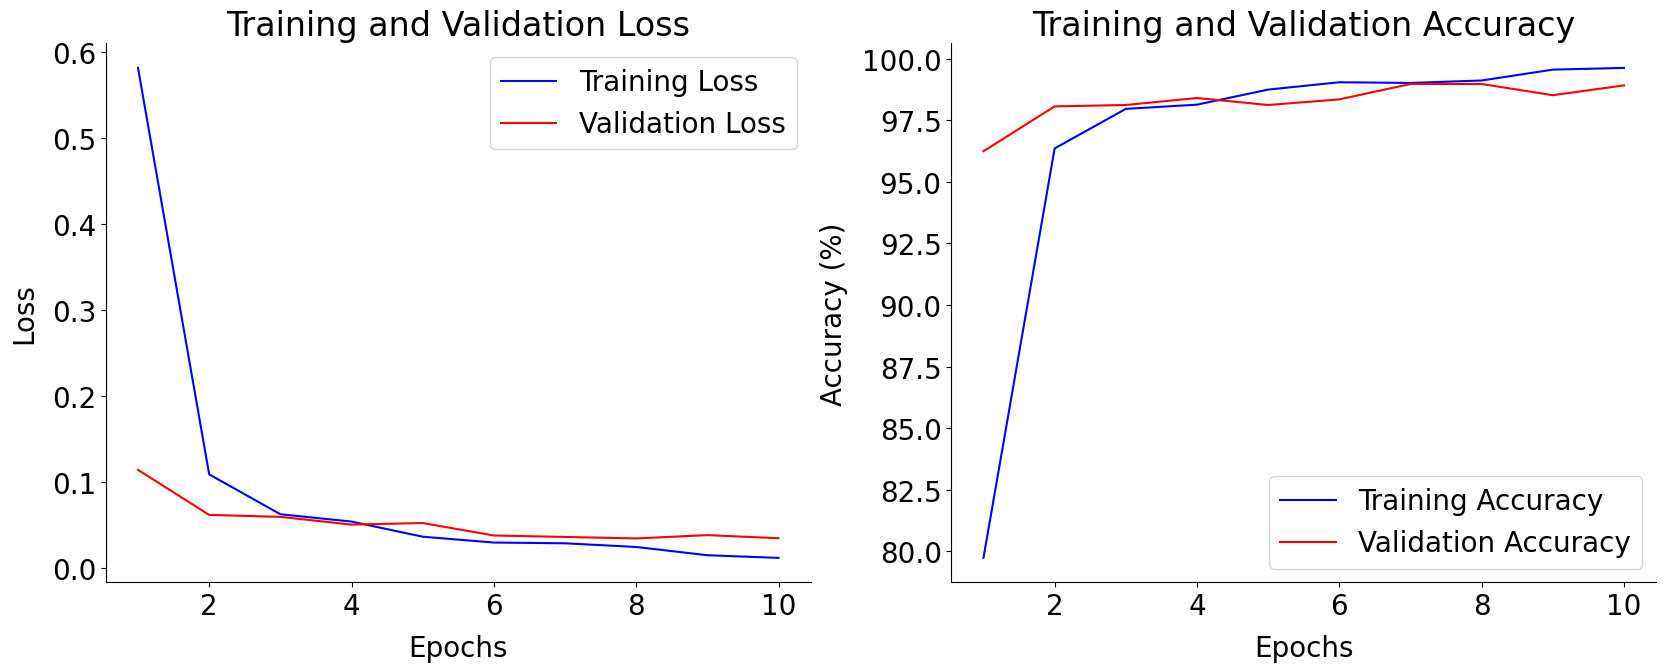

In [ ]:
plot_training_history(best_history)

In [ ]:
evaluate_model(best_model, test_loader, device, classes=["cherry", "tomato", "strawberry"])


Evaluation Results:
Test Accuracy: 99.00%

Classification Report:
              precision    recall  f1-score   support

      cherry       0.99      0.98      0.99       500
      tomato       0.99      0.99      0.99       500
  strawberry       0.99      1.00      0.99       500

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500


Confusion Matrix:
Predicted →
Actual ↓
[[492   5   3]
 [  3 495   2]
 [  2   0 498]]
